# David Braslow Module 5 Project: LANL Earthquake Prediction

# Abstract

The data for this competition come from a Kaggle competition: [LANL Earthquake Prediction](https://www.kaggle.com/c/LANL-Earthquake-Prediction). Data were collected from earthquake simulations in a laboratory setting. The competition aims to solve the following problem: is it possible to predict the timing of aperiodic earthquakes using acoustic data recorded before the earthquake? Prior work showed that the prediction of laboratory earthquakes from continuous seismic data is possible in the case of quasi-periodic laboratory seismic cycles. However, aperiodic eqarthquakes remain difficult to predict.

Under the constraints of the competition rules, I find that it is possible to use tree-based regression algorithms to improve the prediction of laboratory earthquakes using features engineered from raw acoustic data. While these models yield a substantial improvement over a dummy model, they still include a substantial amount of error. Nonetheless, these models may still be useful for further seismology research and for future development of public earthquake early-warning systems.

# Initialization

## Load packages

In [1]:
import gc
import os
import time
import logging
import datetime
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal, stats
from scipy.signal import butter, convolve, deconvolve, hann, hilbert
from statsmodels.robust import mad

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import pywt 
from tsfresh.feature_extraction import feature_calculators

from itertools import product
from tqdm import tqdm_notebook
from joblib import Parallel, delayed

warnings.filterwarnings("ignore")

## Load the data

In [2]:
#Set File Path
IS_LOCAL = True
if(IS_LOCAL):
    PATH="../dsc-5-capstone-project-online-ds-sp-000/LANL-Earthquake-Prediction"
else:
    PATH="../input/"
os.listdir(PATH)

['lgbm_importances.png',
 'sample_submission.csv',
 'submission.csv',
 'test',
 'train.csv']

In [3]:
# Explore Test Folder
print("There are {} files in test folder".format(len(os.listdir(os.path.join(PATH, 'test' )))))

There are 2624 files in test folder


In [40]:
%%time
# Load Train Data
train_df = pd.read_csv(os.path.join(PATH,'train.csv'), dtype={'acoustic_data': np.int16, 'time_to_failure': np.float32})

Wall time: 2min 8s


In [41]:
print("Train: rows:{} cols:{}".format(train_df.shape[0], train_df.shape[1]))

Train: rows:629145480 cols:2


In [42]:
# Examine some train rows
pd.options.display.precision = 15
train_df.head()

,acoustic_data,time_to_failure
0,12,1.469099998474121
1,6,1.469099998474121
2,8,1.469099998474121
3,5,1.469099998474121
4,8,1.469099998474121


# Scrubbing the Data

The test segments are 150,000 rows each, and I assume they are independent. I therefore split the train data into segments of the same size. I then calculate a large number of features for each segment. For demonstration purposes, I create only 1000 train samples.

In [7]:
SEGMENT_ROWS = 150000

## Feature Generation

In [58]:
def add_trend_feature(arr):
    idx = np.array(range(len(arr)))
    lr = LinearRegression()
    lr.fit(idx.reshape(-1, 1), arr)
    return lr.coef_[0]

def classic_sta_lta(x, length_sta, length_lta):
    sta = np.cumsum(x ** 2)

    # Convert to float
    sta = np.require(sta, dtype=np.float)

    # Copy for LTA
    lta = sta.copy()

    # Compute the STA and the LTA
    sta[length_sta:] = sta[length_sta:] - sta[:-length_sta]
    sta /= length_sta
    lta[length_lta:] = lta[length_lta:] - lta[:-length_lta]
    lta /= length_lta

    # Pad zeros
    sta[:length_lta - 1] = 0

    ratio = sta / lta   
    ratio = ratio[~np.isnan(ratio)]
    ratio = ratio[~np.isinf(ratio)]
    
    return ratio

def calc_change_rate(x):
    change = (np.diff(x) / x[:-1])
    change = change[~np.isnan(change)]
    change = change[~np.isinf(change)]
    return np.mean(change)

def mad(data, axis=None):
    return np.mean(np.absolute(data - np.mean(data, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold
    sigma = (1/0.6745) * mad(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

In [61]:
class FeatureGenerator(object):
    
    def __init__(self, dtype, n_jobs=1, n_samples=1000, n_cycles = None):
        self.segment_rows = 150000
        self.dtype = dtype
        self.filename = None
        self.n_jobs = n_jobs
        self.test_files = []
        
        self.n_cycles = n_cycles
        self.len_train = 629145480
        
        
        if self.dtype == 'train':
            self.filename = PATH + '/train.csv'
            
            if self.n_cycles:
                self.n_samples = 0
                self.cycle_shift = round(self.segment_rows/self.n_cycles)
                for cycle in range(self.n_cycles):
                    cycle_samples = np.floor((self.len_train - cycle * self.cycle_shift)/self.segment_rows).astype(int)
                    self.n_samples += cycle_samples
            else:
                self.n_samples = n_samples
                
        else:
            submission = pd.read_csv(PATH + '/sample_submission.csv')
            for seg_id in submission.seg_id.values:
                self.test_files.append((seg_id, PATH + '/test/' + seg_id + '.csv'))
            self.n_samples = len(submission.seg_id.values)
    
    # Define generator to provide acoustic data chunks
    def read_chunks(self):
        if self.dtype == 'train':
#             total_rows = train_df.shape[0]
#             scaling_factor = ((total_rows - self.segment_rows) / (self.n_samples - 1))
#             seg_inds = np.round(np.array(range(0, self.n_samples)) * scaling_factor).astype(int)
            
            iterator_df = pd.read_csv(PATH + '/train.csv', skiprows = 1, iterator=True, chunksize=150000, header=None, 
                      names = ['acoustic_data', 'time_to_failure'],  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
            train_data_cycle = 0
    
            for counter in range(self.n_samples):
                try:
                    df = iterator_df.get_chunk()
                except:
                    train_data_cycle += 1
                    iterator_df = pd.read_csv(PATH + '/train.csv', skiprows = 1 + train_data_cycle*50000, iterator=True, chunksize=150000, header=None, 
                          names = ['acoustic_data', 'time_to_failure'],  dtype={'acoustic_data': np.float64, 'time_to_failure': np.float64})
                    df = iterator_df.get_chunk()
                                    
                x = df['acoustic_data'].values
                y = df['time_to_failure'].values[-1]
                seg_id = 'train_' + str(counter)
                del df
                yield seg_id, x, y

        else:
            for seg_id, f in self.test_files:
                df = pd.read_csv(f, dtype={'acoustic_data': np.float64})
                x = df.acoustic_data.values[-self.segment_rows:]
                del df
                yield seg_id, x, -999
    
    #Call feature function for each of 6 data transformations, collect into one dictionary
    def get_features(self, x, y, seg_id):
        """
        Gets six groups of features: from untransformed, real, and imaginary parts of FFT, from raw and denoised data.
        """
        
        # Untransformed signals - raw and denoised
        raw = x
        ur_dict = self.features(raw, 'ur')
    
        denoised = denoise_signal(x)
        ud_dict = self.features(denoised, 'ud')
        
        # FFT transformed signals - raw and denoised
        zc_raw = np.fft.fft(raw)
        realFFT_raw = np.real(zc_raw)
        imagFFT_raw = np.imag(zc_raw)
        
        rr_dict = self.features(realFFT_raw, 'rr')
        ir_dict = self.features(imagFFT_raw, 'ir')

        zc_den = np.fft.fft(denoised)
        realFFT_den = np.real(zc_den)
        imagFFT_den = np.imag(zc_den)
        
        rd_dict = self.features(realFFT_den, 'rd')
        id_dict = self.features(imagFFT_den, 'id')
        
        dict_tuples = zip(['ur', 'rr', 'ir', 'ud', 'rd', 'id'], [ur_dict, rr_dict, ir_dict, ud_dict, rd_dict, id_dict])
#        dict_tuples = zip(['ur', 'ud'], [ur_dict, ud_dict])
        main_dict = {}
        
        main_dict['seg_id'] = seg_id   
        main_dict['target'] = y        
        
        for prefix, p_dict in dict_tuples:
            for k, v in p_dict.items():
                    main_dict[f'{prefix}_{k}'] = v
                    
        return main_dict
        
    #Calculate features from data
    def features(self, x, type = None):
        feature_dict = dict()


        # lists with parameters to iterate over them
        percentiles = [5, 10, 25, 50, 75, 90]
        hann_windows = [150, 5000, 15000]
        spans = [50, 150, 500, 1500, 5000, 15000]
        slices = [1000, 3000, 10000, 30000, 50000]
        windows = [10, 30, 100, 300, 1000, 3000, 10000]
        borders = list(range(-4000, 4001, 1000))
        peaks = [10, 20, 50, 100]
        coefs = [1, 5, 10, 50, 100]
        lags = [10, 100, 1000, 10000]
        autocorr_lags = [5, 10, 30, 100, 300, 1000, 3000, 10000]
        
        # transforms of X used repeatedly
        abs_x = np.abs(x)
        x_ser = pd.Series(x)
        
        # basic summary stats
        feature_dict['mean'] = np.mean(x)
        feature_dict['std'] = np.std(x)
        feature_dict['max'] = np.max(x)
        feature_dict['min'] = np.min(x)
        feature_dict['sum'] = np.sum(x)

        # intermediate summary stats
        feature_dict['mad'] = mad(x)
        feature_dict['kurt'] = stats.kurtosis(x)
        feature_dict['skew'] = stats.skew(x)
        feature_dict['med'] = np.median(x)
        feature_dict['ave10'] = stats.trim_mean(x, 0.1)
        
        # basic stats on absolute values
        feature_dict['mean_change_abs'] = np.mean(np.diff(x))
        feature_dict['abs_max'] = np.max(abs_x)
        feature_dict['abs_mean'] = np.mean(abs_x)
        feature_dict['abs_std'] = np.std(abs_x)

        # Harmonic, Geometric and Hilbert means
        feature_dict['hmean'] = stats.hmean(abs_x[np.nonzero(abs_x)[0]])
        feature_dict['gmean'] = stats.gmean(abs_x[np.nonzero(abs_x)[0]]) 
        feature_dict['Hilbert_mean'] = np.abs(hilbert(x)).mean()
        
        # K-statistics and moments
#         for i in range(3, 5):
#             feature_dict[f'kstat_{i}'] = stats.kstat(x, i)
#             feature_dict[f'moment_{i}'] = stats.moment(x, i)

#         for i in [1, 2]:
#             feature_dict[f'kstatvar_{i}'] = stats.kstatvar(x, i)
                
        # Range stats
        feature_dict['max_to_min'] = np.max(x) / np.abs(np.min(x))
        feature_dict['max_to_min_diff'] = np.max(x) - np.abs(np.min(x))
        
        # Change rates for slices of data
        feature_dict['mean_change_rate'] = calc_change_rate(x)
        
        for slice_length, direction in product([1000, 3000, 10000, 30000], ['first', 'last']):
            if direction == 'first':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'mean_change_rate_{direction}_{slice_length}'] = calc_change_rate(x[-slice_length:])

        # Percentiles on original and absolute values
        if (type != 'ur'):
            feature_dict['iqr'] = np.subtract(*np.percentile(x, [75, 25]))
            feature_dict['iqr1'] = np.subtract(*np.percentile(x, [95, 5]))
            for p in percentiles:
                feature_dict[f'percentile_{p}'] = np.percentile(x, p)
                feature_dict[f'abs_percentile_{p}'] = np.percentile(abs_x, p)
        
        # Trend features
        feature_dict['trend'] = add_trend_feature(x)
        feature_dict['abs_trend'] = add_trend_feature(abs_x)

        # STA/LTA Ratios
        feature_dict['classic_sta_lta1_mean'] = classic_sta_lta(x, 500, 10000).mean()
        feature_dict['classic_sta_lta2_mean'] = classic_sta_lta(x, 5000, 100000).mean()
        feature_dict['classic_sta_lta3_mean'] = classic_sta_lta(x, 3333, 6666).mean()
        feature_dict['classic_sta_lta4_mean'] = classic_sta_lta(x, 10000, 25000).mean()
        feature_dict['classic_sta_lta5_mean'] = classic_sta_lta(x, 50, 1000).mean()
        feature_dict['classic_sta_lta6_mean'] = classic_sta_lta(x, 100, 5000).mean()
        feature_dict['classic_sta_lta7_mean'] = classic_sta_lta(x, 333, 666).mean()
        feature_dict['classic_sta_lta8_mean'] = classic_sta_lta(x, 4000, 10000).mean()
            
        # Hann windows
        for hw in hann_windows:
            feature_dict[f'Hann_window_mean_{hw}'] = (convolve(x, hann(hw), mode='same') / sum(hann(hw))).mean()     

        # Summary statistics on various slices of data
        for agg_type, slice_length, direction in product([np.std, np.min, np.max, np.mean], slices, ['first', 'last']):
            agg_name = agg_type.__name__
            if direction == 'first':
                feature_dict[f'{agg_name}_{direction}_{slice_length}'] = agg_type(x[:slice_length])
            elif direction == 'last':
                feature_dict[f'{agg_name}_{direction}_{slice_length}'] = agg_type(x[-slice_length:])

        # Statistics on rolling windows of various sizes
        for w in windows:
            x_roll_std = x_ser.rolling(w).std().dropna().values
            x_roll_mean = x_ser.rolling(w).mean().dropna().values

            feature_dict[f'ave_roll_std_{w}'] = x_roll_std.mean()
            feature_dict[f'std_roll_std_{w}'] = x_roll_std.std()
            feature_dict[f'max_roll_std_{w}'] = x_roll_std.max()
            feature_dict[f'min_roll_std_{w}'] = x_roll_std.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_std_{p}_window_{w}'] = np.percentile(x_roll_std, p)

            feature_dict[f'av_change_abs_roll_std_{w}'] = np.mean(np.diff(x_roll_std))
            feature_dict[f'av_change_rate_roll_std_{w}'] = np.mean(np.nonzero((np.diff(x_roll_std) / x_roll_std[:-1]))[0])
            feature_dict[f'abs_max_roll_std_{w}'] = np.abs(x_roll_std).max()

            feature_dict[f'ave_roll_mean_{w}'] = x_roll_mean.mean()
            feature_dict[f'std_roll_mean_{w}'] = x_roll_mean.std()
            feature_dict[f'max_roll_mean_{w}'] = x_roll_mean.max()
            feature_dict[f'min_roll_mean_{w}'] = x_roll_mean.min()

            for p in percentiles:
                feature_dict[f'percentile_roll_mean_{p}_window_{w}'] = np.percentile(x_roll_mean, p)

            feature_dict[f'av_change_abs_roll_mean_{w}'] = np.mean(np.diff(x_roll_mean))
            feature_dict[f'av_change_rate_roll_mean_{w}'] = np.mean(np.nonzero((np.diff(x_roll_mean) / x_roll_mean[:-1]))[0])
            feature_dict[f'abs_max_roll_mean_{w}'] = np.abs(x_roll_mean).max()
            
        # Exponential rolling statistics
        ewma = pd.Series.ewm
        for s in spans:
            feature_dict[f'exp_Moving_average_{s}_mean'] = (ewma(x_ser, span=s).mean(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_average_{s}_std'] = (ewma(x_ser, span=s).mean(skipna=True)).std(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_mean'] = (ewma(x_ser, span=s).std(skipna=True)).mean(skipna=True)
            feature_dict[f'exp_Moving_std_{s}_std'] = (ewma(x_ser, span=s).std(skipna=True)).std(skipna=True)
        
        # Counts of large amplitudes
        feature_dict['count_big'] = len(x[np.abs(x) > 500])

        for slice_length, threshold in product([50000, 100000, 150000],
                                                     [5, 10, 20, 50, 100]):
            feature_dict[f'count_big_{slice_length}_threshold_{threshold}'] = (np.abs(x[-slice_length:]) > threshold).sum()
            feature_dict[f'count_big_{slice_length}_less_threshold_{threshold}'] = (np.abs(x[-slice_length:]) < threshold).sum()
        
        # Time Series Features from tsfresh
        feature_dict['abs_energy'] = feature_calculators.abs_energy(x)
        feature_dict['abs_sum_of_changes'] = feature_calculators.absolute_sum_of_changes(x)
        feature_dict['count_above_mean'] = feature_calculators.count_above_mean(x)
        feature_dict['count_below_mean'] = feature_calculators.count_below_mean(x)
        feature_dict['mean_abs_change'] = feature_calculators.mean_abs_change(x)
        feature_dict['mean_change'] = feature_calculators.mean_change(x)
        feature_dict['var_larger_than_std_dev'] = feature_calculators.variance_larger_than_standard_deviation(x)
        feature_dict['range_minf_m4000'] = feature_calculators.range_count(x, -np.inf, -4000)
        feature_dict['range_p4000_pinf'] = feature_calculators.range_count(x, 4000, np.inf)

        for i, j in zip(borders, borders[1:]):
            feature_dict[f'range_{i}_{j}'] = feature_calculators.range_count(x, i, j)

        feature_dict['ratio_unique_values'] = feature_calculators.ratio_value_number_to_time_series_length(x)
        feature_dict['first_loc_min'] = feature_calculators.first_location_of_minimum(x)
        feature_dict['first_loc_max'] = feature_calculators.first_location_of_maximum(x)
        feature_dict['last_loc_min'] = feature_calculators.last_location_of_minimum(x)
        feature_dict['last_loc_max'] = feature_calculators.last_location_of_maximum(x)

        for lag in lags:
            feature_dict[f'time_rev_asym_stat_{lag}'] = feature_calculators.time_reversal_asymmetry_statistic(x, lag)
        for autocorr_lag in autocorr_lags:
            feature_dict[f'autocorrelation_{autocorr_lag}'] = feature_calculators.autocorrelation(x, autocorr_lag)
            feature_dict[f'c3_{autocorr_lag}'] = feature_calculators.c3(x, autocorr_lag)

        for coeff, attr in product([1, 2, 3, 4, 5], ['real', 'imag', 'angle']):
            feature_dict[f'fft_{coeff}_{attr}'] = list(feature_calculators.fft_coefficient(x, [{'coeff': coeff, 'attr': attr}]))[0][1]

        feature_dict['long_strk_above_mean'] = feature_calculators.longest_strike_above_mean(x)
        feature_dict['long_strk_below_mean'] = feature_calculators.longest_strike_below_mean(x)
        feature_dict['cid_ce_0'] = feature_calculators.cid_ce(x, 0)
        feature_dict['cid_ce_1'] = feature_calculators.cid_ce(x, 1)

        for p in percentiles:
            feature_dict[f'binned_entropy_{p}'] = feature_calculators.binned_entropy(x, p)

        feature_dict['num_crossing_0'] = feature_calculators.number_crossing_m(x, 0)

        for peak in peaks:
            feature_dict[f'num_peaks_{peak}'] = feature_calculators.number_peaks(x, peak)

        for c in coefs:
            feature_dict[f'spkt_welch_density_{c}'] = list(feature_calculators.spkt_welch_density(x, [{'coeff': c}]))[0][1]
            feature_dict[f'time_rev_asym_stat_{c}'] = feature_calculators.time_reversal_asymmetry_statistic(x, c)  

        # Return dictionary with all features   
        return feature_dict

    def generate(self):
        dict_list = []
        res = Parallel(n_jobs=self.n_jobs, backend='threading')(delayed(self.get_features)(x, y, s) for s, x, y in tqdm_notebook(self.read_chunks(), total=self.n_samples))
        for r in res:
            dict_list.append(r)

        return pd.DataFrame(dict_list).set_index('seg_id')

In [62]:
training_fg = FeatureGenerator(dtype='train', n_jobs = 7, n_cycles = 3)
training_data = training_fg.generate()
gc.collect()

2365

In [63]:
test_fg = FeatureGenerator(dtype='test', n_jobs= 7)
test_data = test_fg.generate()

In [64]:
print(training_data.shape)

(12580, 2459)


In [65]:
train_X = training_data.drop('target', axis = 1)
train_y = training_data['target']
test_X = test_data.drop('target', axis = 1)

In [143]:
# Dropping columns with no variance
for col in train_X.columns:
    if train_X[col].std() == 0:
        print(col)
        train_X.drop(col, axis = 1, inplace = True)
        test_X.drop(col, axis = 1, inplace = True)

id_var_larger_than_std_dev
ir_var_larger_than_std_dev
rd_first_loc_max
rd_var_larger_than_std_dev
rr_first_loc_max
rr_var_larger_than_std_dev
ur_var_larger_than_std_dev


In [144]:
train_X.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/train_X_051819_v1.pkl")
train_y.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/train_y_051819_v1.pkl")
test_X.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/test_X_051819_v1.pkl")

### Scaling the data

In [102]:
train_X = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/train_X_051819_v1.pkl")
train_y = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/train_y_051819_v1.pkl")
test_X = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/test_X_051819_v1.pkl")

In [103]:
# n_samples = np.floor(train_df.shape[0]/150000).astype(int)
# print(n_samples)

In [104]:
# train_X = train_X.iloc[:n_samples]
# train_y = train_y.iloc[:n_samples]
# test_X = test_X.iloc[:n_samples]

In [105]:
train_X.shape

(12580, 2451)

In [106]:
scaler = StandardScaler()
scaler.fit(train_X)
scaled_train_X = pd.DataFrame(scaler.transform(train_X), columns=train_X.columns)
scaled_test_X = pd.DataFrame(scaler.transform(test_X), columns=test_X.columns)

In [107]:
scaled_train_X.head()

,id_Hann_window_mean_150,id_Hann_window_mean_15000,id_Hann_window_mean_5000,id_Hilbert_mean,id_abs_energy,id_abs_max,id_abs_max_roll_mean_10,id_abs_max_roll_mean_100,id_abs_max_roll_mean_1000,id_abs_max_roll_mean_10000,...,ur_std_roll_std_3000,ur_sum,ur_time_rev_asym_stat_1,ur_time_rev_asym_stat_10,ur_time_rev_asym_stat_100,ur_time_rev_asym_stat_1000,ur_time_rev_asym_stat_10000,ur_time_rev_asym_stat_5,ur_time_rev_asym_stat_50,ur_trend
0,-1.868025296730343,-0.307867119968957,-1.031520958949976,-0.181324492413729,-0.081373060784764,-0.036132759204261,0.553692268020342,0.014938926032560,-0.145341919932276,-0.226075897666160,...,-0.177976571641340,1.416823061274028,0.017624435864879,0.023428205561757,0.006884098150869,0.023572085709051,-0.044940716043807,0.023439320799592,-0.006303815574594,-1.764341778974555
1,0.617486569483899,0.137657579768559,0.423120697003740,0.030545671940883,-0.065789691014123,0.007242205534134,-0.209385712143007,-0.326470684526183,-0.248034889296313,-0.302666172633878,...,0.015743631027025,0.802073951256828,0.017502540324692,0.023894373171805,0.006690446946730,0.023529921571459,-0.045342029735137,0.024339424884943,-0.006167001014674,0.488196132447382
2,1.602236594105866,0.282906532545382,0.876375308729919,0.087123327518538,-0.060858343265067,0.080847498203487,0.504713776746398,-0.141235914918180,-0.115172756672712,-0.229672527152221,...,-0.026604641203208,1.503320683608041,0.017038814700234,0.023027319482238,0.007304888671439,0.023643647090035,-0.015525324829838,0.022735615623125,-0.006001120219182,2.134532830001319
3,0.353103223307276,0.021795943681444,0.142530675739899,0.048068897737055,-0.061860807886322,0.092463539242257,-0.201858399665372,-0.263662728161442,-0.180071144884529,-0.022663243056184,...,0.065227258933937,1.487196201646913,0.018093046399149,0.023544525617562,0.008272025554111,0.024025844780557,-0.033593707052685,0.023724171814507,-0.007067613716508,0.880842619542917
4,-0.629388613984889,-0.123647429803665,-0.354470773712179,0.120712617067539,-0.056700736042159,0.041584121721062,0.210142227518463,0.310167109146876,-0.074696050817168,0.045198818496467,...,0.099678783762354,1.512353499345495,0.017969401379634,0.023548702530544,0.007412482302284,0.023219113283770,-0.024351955702832,0.023685935315630,-0.005846588492127,-0.361562632575097


Drop columns with no variance

In [108]:
for col in scaled_train_X.columns:
    if scaled_train_X[col].std() == 0:
        print(col)
        scaled_train_X.drop(col, axis = 1, inplace = True)
        scaled_test_X.drop(col, axis = 1, inplace = True)

## Feature Selection

First, drop features with correlations above 0.99

In [109]:
CORR_LIM = 0.99
corr_df = scaled_train_X.corr()
corr_mat = corr_df.values

col_list = scaled_train_X.columns
col_remove_list = []
for i, col in enumerate(col_list):
        
        #Get correlations for that columns
        col_corr = corr_df[col]
        
        #Remove correlation with itself
        col_corr = col_corr.drop(col, axis = 0)
        
        #Get maximum correlation with other variables
        max_corr = col_corr.max()
        min_corr = col_corr.min()
        if abs(min_corr) > max_corr:
            max_corr = abs(min_corr)
        
        #If this column has a large correlation, chose it for removal
        if max_corr > CORR_LIM:
            print(col, max_corr)
            col_remove_list.append(col)
            corr_df.drop(col, axis = 0, inplace=True)
            corr_df.drop(col, axis = 1, inplace=True)
            
print(len(col_remove_list))            

id_Hilbert_mean 0.9999971756790271
id_abs_energy 0.9999997920342152
id_abs_max 1.0
id_abs_max_roll_mean_10 0.9999974523357663
id_abs_max_roll_mean_100 0.9999999978497456
id_abs_max_roll_mean_1000 0.9999999996702449
id_abs_max_roll_mean_10000 0.9999997553114534
id_abs_max_roll_mean_30 0.9999998207394749
id_abs_max_roll_mean_300 0.9999999998726445
id_abs_max_roll_mean_3000 0.9999999801670848
id_abs_max_roll_std_10 1.0
id_abs_max_roll_std_100 1.0
id_abs_max_roll_std_1000 1.0
id_abs_max_roll_std_10000 1.0
id_abs_max_roll_std_30 1.0
id_abs_max_roll_std_300 1.0
id_abs_max_roll_std_3000 1.0
id_abs_mean 1.0
id_abs_percentile_10 0.9926591927807127
id_abs_percentile_25 0.9984567370296731
id_abs_percentile_5 0.992460680537915
id_abs_percentile_50 0.9999999995370185
id_abs_percentile_75 0.9997464503526012
id_abs_percentile_90 0.9999999999460351
id_abs_std 0.9999936497114755
id_abs_sum_of_changes 0.9999996897066276
id_abs_trend 0.9999339717490603
id_amax_first_1000 0.9999999999999999
id_amax_first_

id_percentile_75 0.9998823329969718
id_percentile_90 0.9994727492696838
id_percentile_roll_mean_10_window_10 0.9999999514930398
id_percentile_roll_mean_10_window_100 0.9999999897881675
id_percentile_roll_mean_10_window_1000 0.9999999970147022
id_percentile_roll_mean_10_window_10000 0.9999999842027488
id_percentile_roll_mean_10_window_30 0.999999981531963
id_percentile_roll_mean_10_window_300 0.9999999772639545
id_percentile_roll_mean_10_window_3000 0.9999999958591023
id_percentile_roll_mean_25_window_10 0.9999999910711601
id_percentile_roll_mean_25_window_100 0.9999999944566657
id_percentile_roll_mean_25_window_1000 0.9999999971463794
id_percentile_roll_mean_25_window_10000 0.9999999978086315
id_percentile_roll_mean_25_window_30 0.9999999936303561
id_percentile_roll_mean_25_window_300 0.999999995876268
id_percentile_roll_mean_25_window_3000 0.9999999973606011
id_percentile_roll_mean_5_window_10 0.9990285424630401
id_percentile_roll_mean_5_window_100 0.9947873826484993
id_percentile_rol

ir_binned_entropy_75 0.9945691172044059
ir_cid_ce_0 0.9991925521726046
ir_classic_sta_lta1_mean 0.9993269383152763
ir_classic_sta_lta2_mean 0.9996060715825976
ir_classic_sta_lta3_mean 0.9999994549144062
ir_classic_sta_lta4_mean 0.9993064862272651
ir_classic_sta_lta5_mean 0.9915412868306366
ir_classic_sta_lta6_mean 0.9939441431587313
ir_classic_sta_lta7_mean 0.9999703572473324
ir_classic_sta_lta8_mean 0.9989735226533859
ir_count_above_mean 0.9999987845770483
ir_count_below_mean 0.9999987809263761
ir_count_big_100000_threshold_10 0.9982633792816916
ir_count_big_100000_threshold_100 0.9927509758169973
ir_count_big_100000_threshold_20 0.997464339884831
ir_count_big_100000_threshold_5 0.9986672469512675
ir_count_big_100000_threshold_50 0.9952566283367841
ir_count_big_150000_threshold_10 0.9986794626642321
ir_count_big_150000_threshold_20 0.9941854060603477
ir_count_big_150000_threshold_5 0.9987018872428939
ir_exp_Moving_average_1500_std 0.9911577694381085
ir_exp_Moving_average_150_std 0.996

rd_av_change_abs_roll_mean_100 0.9996016543711064
rd_av_change_abs_roll_mean_1000 0.9997910698362087
rd_av_change_abs_roll_mean_10000 0.9990229629703564
rd_av_change_abs_roll_mean_30 0.9991991517394193
rd_av_change_abs_roll_mean_300 0.9997670481550035
rd_av_change_abs_roll_mean_3000 0.9995500848863351
rd_av_change_abs_roll_std_10 0.9997050224354563
rd_av_change_abs_roll_std_100 0.9995221994850327
rd_av_change_abs_roll_std_1000 0.9989305764102964
rd_av_change_abs_roll_std_10000 0.9990138190256063
rd_av_change_abs_roll_std_30 0.9996447993722569
rd_av_change_abs_roll_std_300 0.999313087907881
rd_av_change_abs_roll_std_3000 0.9970784319114274
rd_av_change_rate_roll_mean_10 1.0000000000005973
rd_av_change_rate_roll_mean_100 1.0000000000005884
rd_av_change_rate_roll_mean_1000 1.000000000000597
rd_av_change_rate_roll_mean_10000 1.0000000000006062
rd_av_change_rate_roll_mean_30 1.0000000000005984
rd_av_change_rate_roll_mean_300 1.0000000000005982
rd_av_change_rate_roll_mean_3000 1.000000000000

rd_percentile_roll_std_90_window_10 0.9992416751254048
rd_percentile_roll_std_90_window_100 0.9995525052852963
rd_percentile_roll_std_90_window_1000 0.9997732921069042
rd_percentile_roll_std_90_window_10000 0.9998553912599848
rd_percentile_roll_std_90_window_30 0.9993808782989911
rd_percentile_roll_std_90_window_300 0.9996550796615116
rd_percentile_roll_std_90_window_3000 0.9998698005150758
rd_range_minf_m4000 0.9991384548168455
rd_range_p4000_pinf 0.9991423439204068
rd_skew 0.9977356478898584
rd_spkt_welch_density_1 0.999999929678567
rd_spkt_welch_density_10 0.9999999226884764
rd_spkt_welch_density_100 0.9999997250535037
rd_spkt_welch_density_5 0.9999956544617346
rd_spkt_welch_density_50 0.9999996839548045
rd_std 0.9999807347166257
rd_std_first_1000 0.9999711753656693
rd_std_first_10000 0.9999937533186252
rd_std_first_3000 0.9999984033511479
rd_std_first_30000 0.9999999700930639
rd_std_first_50000 0.9999943479054021
rd_std_last_1000 0.9992345387698176
rd_std_last_10000 0.9999423248047

ud_abs_max_roll_mean_100 0.9998767744169393
ud_abs_max_roll_mean_1000 1.0
ud_abs_max_roll_mean_10000 1.0
ud_abs_max_roll_mean_30 0.9999684114324394
ud_abs_max_roll_mean_300 0.9997048710672813
ud_abs_max_roll_mean_3000 1.0
ud_abs_max_roll_std_10 1.0
ud_abs_max_roll_std_100 1.0
ud_abs_max_roll_std_1000 1.0
ud_abs_max_roll_std_10000 1.0
ud_abs_max_roll_std_30 1.0
ud_abs_max_roll_std_300 1.0
ud_abs_max_roll_std_3000 1.0
ud_abs_mean 0.9992348400711095
ud_abs_percentile_25 0.9915208687959829
ud_abs_percentile_90 0.9919133546768685
ud_abs_std 0.9999489447737564
ud_abs_sum_of_changes 0.9999983090271769
ud_abs_trend 0.9999112659664426
ud_amax_first_1000 0.9962052143747981
ud_amax_first_10000 0.9994115994842763
ud_amax_first_3000 0.9979351272496959
ud_amax_first_30000 0.9998143756616612
ud_amax_first_50000 0.9998828646208882
ud_amax_last_1000 0.9960540236410959
ud_amax_last_10000 0.9994086791090926
ud_amax_last_3000 0.9978283041469937
ud_amax_last_30000 0.999841102475771
ud_amax_last_50000 0.999

ud_percentile_roll_mean_25_window_100 0.9991217191780636
ud_percentile_roll_mean_25_window_1000 0.9997310492856197
ud_percentile_roll_mean_25_window_10000 0.9986513862726762
ud_percentile_roll_mean_25_window_30 0.9907308438767529
ud_percentile_roll_mean_25_window_300 0.9987530919040858
ud_percentile_roll_mean_25_window_3000 0.9974917129375502
ud_percentile_roll_mean_50_window_10 0.9998781882211305
ud_percentile_roll_mean_50_window_100 0.9998676367870689
ud_percentile_roll_mean_50_window_1000 0.9998817685717399
ud_percentile_roll_mean_50_window_10000 0.9988438629462428
ud_percentile_roll_mean_50_window_30 0.9995046139491289
ud_percentile_roll_mean_50_window_300 0.999406666378801
ud_percentile_roll_mean_50_window_3000 0.9979401462088279
ud_percentile_roll_mean_5_window_100 0.9910816057099504
ud_percentile_roll_mean_5_window_1000 0.9956818835567051
ud_percentile_roll_mean_5_window_10000 0.99771172410958
ud_percentile_roll_mean_5_window_300 0.9914377177570137
ud_percentile_roll_mean_5_wind

ur_percentile_roll_mean_25_window_300 0.9971073959304513
ur_percentile_roll_mean_25_window_3000 0.9913327257748691
ur_percentile_roll_mean_50_window_10 0.9931182890198194
ur_percentile_roll_mean_50_window_100 0.9996572342246516
ur_percentile_roll_mean_50_window_1000 0.9994365506478405
ur_percentile_roll_mean_50_window_10000 0.9971457584866898
ur_percentile_roll_mean_50_window_30 0.9985173432910205
ur_percentile_roll_mean_50_window_300 0.9980938015332916
ur_percentile_roll_mean_50_window_3000 0.9921984345351501
ur_percentile_roll_mean_5_window_1000 0.9950430501712579
ur_percentile_roll_mean_75_window_100 0.9989464918483192
ur_percentile_roll_mean_75_window_1000 0.9991847001692996
ur_percentile_roll_mean_75_window_10000 0.9959735429352247
ur_percentile_roll_mean_75_window_300 0.9972468889293674
ur_percentile_roll_mean_90_window_100 0.9941590643244687
ur_percentile_roll_mean_90_window_1000 0.9978844241707207
ur_percentile_roll_mean_90_window_300 0.9924480246088685
ur_percentile_roll_std_1

In [110]:
scaled_train_X.drop(col_remove_list, axis = 1, inplace = True)
scaled_test_X.drop(col_remove_list, axis = 1, inplace = True)

Next, drop features with low correlations with the target

In [111]:
CORR_FLOOR = 0.005

col_list = scaled_train_X.columns
col_remove_list2 = []

for i, col in enumerate(col_list):
        
        #Get correlations for that columns
        col_corr = np.corrcoef(scaled_train_X[col].values, train_y.values)[0,1]
        
        #If this column has a large correlation, chose it for removal
        if abs(col_corr) < CORR_FLOOR:
            print(col, col_corr)
            col_remove_list2.append(col)
            
print(len(col_remove_list2))            

id_autocorrelation_10 -0.0018545748652402422
id_autocorrelation_100 0.004223057855432404
id_autocorrelation_1000 -0.00030784371741193127
id_autocorrelation_10000 0.0006917498304104543
id_autocorrelation_3000 0.004144706174821294
id_autocorrelation_5 0.0004302889349754342
id_ave_roll_mean_10 0.004748904228087475
id_ave_roll_mean_300 -0.0025612061313002956
id_c3_5 0.0019437114690780194
id_cid_ce_1 0.0049063613135773235
id_exp_Moving_average_1500_mean 0.004537283103567078
id_exp_Moving_average_500_mean 0.003596243487739759
id_exp_Moving_average_50_mean 0.0046340297897841335
id_fft_1_imag 0.0022889316850163138
id_fft_1_real 0.0035676432346623444
id_fft_2_imag 0.003739243547666829
id_fft_2_real 0.00020434566884313892
id_fft_3_imag 0.0029080964015867007
id_fft_4_imag -0.0008562776021858327
id_fft_5_real 0.004176803947724933
id_last_loc_min 0.003412979889341717
id_max_to_min 0.002459256762479923
id_max_to_min_diff -0.0003979581574476162
id_mean_change_rate_first_10000 0.003621823810667681
id_

In [112]:
scaled_train_X.drop(col_remove_list2, axis = 1, inplace = True)
scaled_test_X.drop(col_remove_list2, axis = 1, inplace = True)

Lastly, describe the features that remain.

In [113]:
# Count features, by type
print(scaled_train_X.shape)
for tr in ['ur', 'rr', 'ir', 'ud', 'rd', 'id']:
    tr_vars = [x for x in scaled_train_X.columns if x[0:2] == tr]
    n_tr_vars = len(tr_vars)
    print(f'{tr} has {n_tr_vars} variables')

(12580, 905)
ur has 226 variables
rr has 228 variables
ir has 162 variables
ud has 100 variables
rd has 114 variables
id has 75 variables


In [114]:
var_list = {}

# Get list of all column types
for col in train_X.columns:
    col_type = col[3:]
    var_list[col_type] = 0

# Get list of preserved column types
for col in scaled_train_X.columns:
    col_type = col[3:]
    var_list[col_type] += 1

col_counts_df = pd.Series(var_list)
#print(col_counts_df.sort_values())
print(col_counts_df[col_counts_df == 0])

Hilbert_mean                           0
abs_max                                0
abs_max_roll_mean_10                   0
abs_max_roll_mean_100                  0
abs_max_roll_mean_1000                 0
abs_max_roll_mean_30                   0
abs_max_roll_std_10                    0
abs_max_roll_std_100                   0
abs_max_roll_std_1000                  0
abs_max_roll_std_10000                 0
abs_max_roll_std_30                    0
abs_max_roll_std_300                   0
abs_max_roll_std_3000                  0
abs_percentile_90                      0
abs_std                                0
abs_sum_of_changes                     0
abs_trend                              0
av_change_abs_roll_mean_30             0
av_change_rate_roll_mean_10            0
av_change_rate_roll_mean_100           0
av_change_rate_roll_mean_1000          0
av_change_rate_roll_mean_10000         0
av_change_rate_roll_mean_30            0
av_change_rate_roll_mean_300           0
av_change_rate_r

In [115]:
submission = pd.read_csv(PATH + '/sample_submission.csv', index_col='seg_id')
scaled_test_X = scaled_test_X.set_index(submission.index)
scaled_test_X.head()

,id_Hann_window_mean_150,id_Hann_window_mean_15000,id_Hann_window_mean_5000,id_autocorrelation_30,id_autocorrelation_300,id_av_change_abs_roll_std_10,id_av_change_abs_roll_std_100,id_av_change_abs_roll_std_1000,id_av_change_abs_roll_std_10000,id_av_change_abs_roll_std_30,...,ur_std_roll_mean_3000,ur_std_roll_std_3000,ur_sum,ur_time_rev_asym_stat_1,ur_time_rev_asym_stat_10,ur_time_rev_asym_stat_100,ur_time_rev_asym_stat_1000,ur_time_rev_asym_stat_10000,ur_time_rev_asym_stat_5,ur_time_rev_asym_stat_50
seg_id,,,,,,,,,,,,,,,,,,,,,
seg_00030f,-0.435368759539827,-0.222958042990729,-0.274204461391352,0.513140498000108,0.560379567126859,0.873838982243930,-0.071437160040602,-0.017136015203761,-0.244123809970259,-0.066787961840056,...,-0.190592470374800,-0.221613405329320,-0.106332257204930,0.017766620821168,0.023601096439573,0.006763839204202,0.023657533860003,-0.034392408116274,0.023486284610534,-0.006367178412221
seg_0012b5,0.567854749107183,-0.000489572381883,0.273661167934305,0.472782511150807,0.030131412340705,0.280252516439797,-0.071152241007076,-0.075753394744873,-0.263464772370634,-0.159834369282965,...,-0.326407300647076,-0.075402353700153,-1.351100853414394,0.018494654147209,0.024310353144050,0.006829951233851,0.023623292979292,-0.028526817698618,0.024152180780619,-0.005898588611900
seg_00184e,0.815767583855933,0.146054865020724,0.450829362097784,-0.626387996140743,0.034547147796094,-0.127470675757426,-0.076083742778369,-0.097618770644419,-0.242837675701413,-0.027458215130424,...,0.030033992633080,0.102916380288251,0.353642531580254,0.019550271797280,0.025330157886125,0.006725496943327,0.023892246472759,-0.032642625545993,0.025222973366839,-0.006368025181570
seg_003339,0.185423068781265,0.205529030803246,0.643167193282172,-2.394665185156394,0.856932711930649,-0.327539363581431,-0.098437821589097,-0.106820001623909,-0.161215774471192,-0.141109267379484,...,-0.284086094962405,-0.244873032925313,0.047769132195643,0.017885115858246,0.023496392699329,0.006976060928189,0.023577216494003,-0.030560879627154,0.023495869134113,-0.006414807797892
seg_0042cc,-0.862408238498224,-0.159570027107303,-0.548137938980782,0.529153077981385,-1.282579260043610,-0.384742707339454,-0.075608182757611,-0.068449698469961,-0.295898195976858,-0.130475661970281,...,0.343305440085055,-0.052940252651846,-1.517315015780951,0.017095752300180,0.024095907548071,0.007190239694782,0.023454355179460,-0.028101357145008,0.023165569498669,-0.006360199740864


In [116]:
scaled_train_X.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/scaled_train_X_052119_v1.pkl")
train_y.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/train_y_052119_v1.pkl")
scaled_test_X.to_pickle("../dsc-5-capstone-project-online-ds-sp-000/scaled_test_X_052119_v1.pkl")

# Exploring the Data

## Visualizing raw data

Here I draw a plot of all acoustic data, along with the associated time to failure. I only plot 0.1% of the data, by sampling every 1000 points of data. Just before each failure there seems to be a large oscillation, but not all large oscillations have a failure following them.

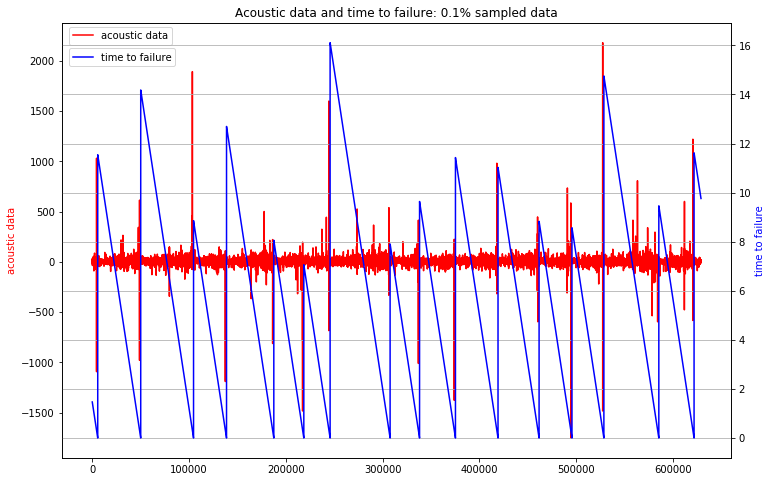

In [43]:
train_ad_sample_df = train_df['acoustic_data'].values[::1000]
train_ttf_sample_df = train_df['time_to_failure'].values[::1000]

def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 0.1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

Here I plot the data for just the first 1% of the train data. There seems to be a lag between the time of the large oscilation and the failure there.

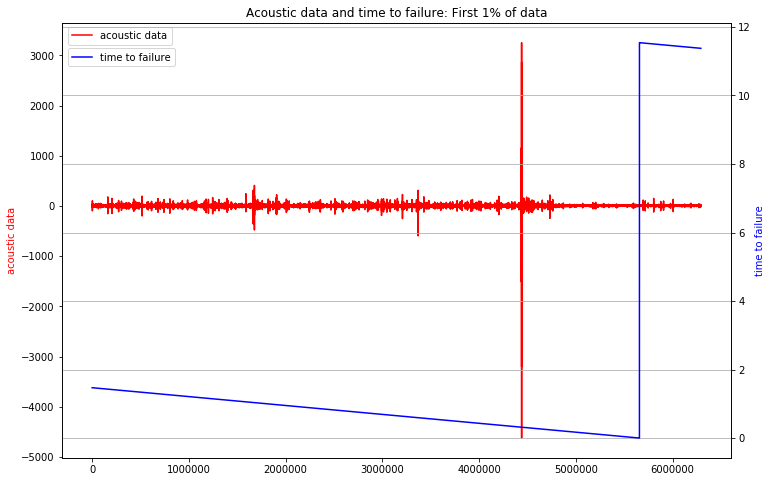

In [44]:
train_ad_sample_df = train_df['acoustic_data'].values[:6291455]
train_ttf_sample_df = train_df['time_to_failure'].values[:6291455]
plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: First 1% of data")
del train_ad_sample_df
del train_ttf_sample_df

Here I plot the time to failure for the first 100000 samples. There is an interesting staircase pattern, which is a result of how the sensor measures the data in binned intervals.

Text(0.5, 0, 'Row')

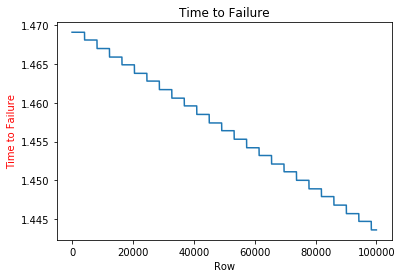

In [46]:
train_ttf_sample_df = train_df['time_to_failure'].values[:100000]
plt.title('Time to Failure')
plt.plot(train_ttf_sample_df)
plt.ylabel('Time to Failure', color='r')
plt.xlabel('Row')


# Model the Data

Due to the large number of features, I choose to use tree-based approaches for this problem. I will start with a dummy regressor, then move on to a simple random forest, and then to gradient boosted methods.

In [117]:
scaled_train_X = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/scaled_train_X_052119_v1.pkl")
train_y = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/train_y_052119_v1.pkl")
scaled_test_X = pd.read_pickle("../dsc-5-capstone-project-online-ds-sp-000/scaled_test_X_052119_v1.pkl")

In [118]:
scaled_train_X.shape

(12580, 905)

## Create Hold-Out Set

In [119]:
from sklearn.model_selection import train_test_split

In [120]:
holdout_perc = 0.2
holdout_num = round(holdout_perc*4194)
holdout_inds = np.random.choice(list(range(4194)), size = holdout_num)
holdout_indices = [x for x in holdout_inds] + [x + 4193 for x in holdout_inds] + [x + 4193 + 4192 for x in holdout_inds]
test_index = list(set(holdout_indices))
train_index = [x for x in list(range(0,12580)) if x not in test_index]

In [121]:
X_train = scaled_train_X.iloc[train_index]
X_test = scaled_train_X.iloc[test_index]
y_train = train_y.iloc[train_index]
y_test = train_y.iloc[test_index]

## Dummy

In [122]:
from sklearn.dummy import DummyRegressor

In [123]:
dum_reg = DummyRegressor()
dum_reg.fit(X_train, y_train)

dum_reg_train_pred = dum_reg.predict(X_train)
dum_reg_train_score = mean_absolute_error(y_train, dum_reg_train_pred)

dum_reg_test_pred = dum_reg.predict(X_test)
dum_reg_test_score = mean_absolute_error(y_test, dum_reg_test_pred)

print('Dummy Regressor')
print(f'Train MAE: {dum_reg_train_score}, Test MAE: {dum_reg_test_score}')

Dummy Regressor
Train MAE: 3.052772227913291, Test MAE: 3.022639465927281


## Random Forest

In [124]:
from sklearn.ensemble import RandomForestRegressor

In [125]:
rf_params = {'n_estimators': 9,
              'criterion': 'mae', 
              'max_depth': 10,
              'n_jobs': 3, 
              'random_state': 123,
              'verbose': 2,
              'warm_start': True}

samp_ind = list(np.random.choice(list(range(len(y_train))), size = 2000))

rf_reg = RandomForestRegressor(**rf_params)
rf_reg.fit(X_train.iloc[samp_ind], y_train.iloc[samp_ind])

rf_reg_train_pred = rf_reg.predict(X_train.iloc[samp_ind])
rf_reg_train_score = mean_absolute_error(y_train.iloc[samp_ind], rf_reg_train_pred)

rf_reg_test_pred = rf_reg.predict(X_test)
rf_reg_test_score = mean_absolute_error(y_test, rf_reg_test_pred)

print('Random Forest Regressor')
print(f'Train MAE: {rf_reg_train_score}, Test MAE: {rf_reg_test_score}')

[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.


building tree 1 of 9building tree 2 of 9building tree 3 of 9


building tree 4 of 9
building tree 5 of 9
building tree 6 of 9
building tree 7 of 9
building tree 8 of 9
building tree 9 of 9


[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   29.5s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:   29.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=3)]: Done   9 out of   9 | elapsed:    0.0s finished


Random Forest Regressor
Train MAE: 1.1052213098629196, Test MAE: 2.057954136110045


In [126]:
gc.collect()

111

In [127]:
rf_feature_importances = pd.DataFrame()
rf_feature_importances['feature_name'] = pd.Series(X_train.columns)
rf_feature_importances['feature_importance'] = pd.Series(rf_reg.feature_importances_)
rf_feature_importances = rf_feature_importances.sort_values('feature_importance')

In [128]:
rf_feature_importances.tail(10)

,feature_name,feature_importance
653,ud_percentile_roll_std_25_window_1000,0.005426924096504
659,ud_percentile_roll_std_50_window_1000,0.005939337578600
851,ur_percentile_roll_std_50_window_3000,0.006638212376232
656,ud_percentile_roll_std_25_window_3000,0.006714962379739
846,ur_percentile_roll_std_25_window_10000,0.012745626039130
844,ur_percentile_roll_std_10_window_10000,0.014003041933711
855,ur_percentile_roll_std_5_window_30,0.037585142642893
646,ud_percentile_roll_std_10_window_1000,0.046255416065411
847,ur_percentile_roll_std_25_window_300,0.140308563378574
856,ur_percentile_roll_std_5_window_300,0.158571406289340


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000018883137898>]],
      dtype=object)

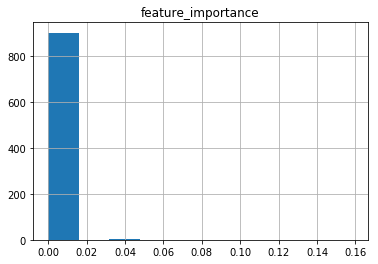

In [129]:
rf_feature_importances.hist()

In [130]:
rf_drop_list = list(rf_feature_importances[rf_feature_importances['feature_importance'] < 0.0005]['feature_name'].values)
print(len(rf_drop_list))

519


In [131]:
X_train_rf = X_train.drop(rf_drop_list, axis = 1)
X_test_rf = X_test.drop(rf_drop_list, axis = 1)

In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [133]:
rf2_params = {'n_estimators': 10,
              'criterion': 'mae', 
              'n_jobs': 2, 
              'random_state': 123,
              'verbose': 2,
              'warm_start': True}

rf_param_search = {'max_depth': [10, 20],
                   'max_features': [None, 0.75],
                   'min_samples_split': [0.01, 0.02] }

rf2_reg = RandomForestRegressor(**rf2_params)

rf_random = GridSearchCV(estimator = rf2_reg, param_grid = rf_param_search, scoring = make_scorer(mean_absolute_error), cv = 3, verbose=2, n_jobs = 3)
rf_random.fit(X_train_rf.iloc[samp_ind], y_train.iloc[samp_ind])
print(rf_random.best_params_)
rf2_params.update(rf_random.best_params_)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  24 out of  24 | elapsed:  1.9min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:   16.6s finished


{'max_depth': 20, 'max_features': 0.75, 'min_samples_split': 0.02}


In [134]:
rf_random.best_score_

2.014686746621729

In [135]:
rf2_reg = RandomForestRegressor(**rf2_params)
rf2_reg.fit(X_train_rf, y_train)
rf2_reg_train_pred = rf2_reg.predict(X_train_rf)
rf2_reg_train_score = mean_absolute_error(y_train, rf2_reg_train_pred)

rf2_reg_test_pred = rf2_reg.predict(X_test_rf)
rf2_reg_test_score = mean_absolute_error(y_test, rf2_reg_test_pred)

print('Random Forest Regressor v2')
print(f'Train MAE: {rf2_reg_train_score}, Test MAE: {rf2_reg_test_score}')

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:  5.8min finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


Random Forest Regressor v2
Train MAE: 1.7529744548976212, Test MAE: 1.9282762184061373


In [136]:
rf2_feature_importances = pd.DataFrame()
rf2_feature_importances['feature_name'] = pd.Series(X_train_rf.columns)
rf2_feature_importances['feature_importance'] = pd.Series(rf2_reg.feature_importances_)
rf2_feature_importances = rf2_feature_importances.sort_values('feature_importance', ascending = False)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000188949C4198>]],
      dtype=object)

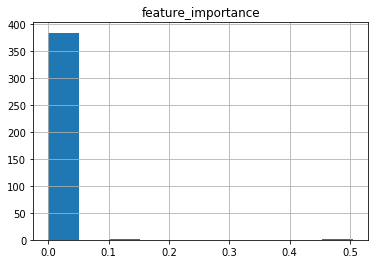

In [137]:
rf2_feature_importances.hist()

In [138]:
rf2_feature_importances.head(20)

,feature_name,feature_importance
361,ur_percentile_roll_std_25_window_300,0.504898414631484
364,ur_percentile_roll_std_5_window_30,0.137929857897817
273,ud_percentile_roll_std_25_window_3000,0.034031778377205
275,ud_percentile_roll_std_50_window_100,0.011815289488922
276,ud_percentile_roll_std_50_window_1000,0.010831432038760
267,ud_percentile_roll_std_10_window_3000,0.009911416914772
238,ud_abs_percentile_50,0.007946699451324
359,ur_percentile_roll_std_10_window_3000,0.007779947975018
358,ur_percentile_roll_std_10_window_10000,0.007555901636465
365,ur_percentile_roll_std_5_window_300,0.006387711527685


In [139]:
rf2_drop_list = list(rf2_feature_importances[rf2_feature_importances['feature_importance'] < 0.001]['feature_name'].values)
print(len(rf2_drop_list))

293


In [140]:
# X_train_rf2 = X_train_rf.drop(rf2_drop_list, axis = 1)
# X_test_rf2 = X_test_rf.drop(rf2_drop_list, axis = 1)

In [141]:
rf2_reg_sub_pred = rf2_reg.predict(scaled_test_X.drop(rf_drop_list, axis = 1))
submission = pd.read_csv(PATH + '/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = rf2_reg_sub_pred
submission.to_csv(PATH + '/submission.csv',index=True)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  10 out of  10 | elapsed:    0.0s finished


## LightGBM

In [142]:
import lightgbm as lgb
from sklearn.model_selection import KFold, RandomizedSearchCV

In [143]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)
train_columns = scaled_train_X.columns.values

In [144]:
lgbm_params = {'n_estimators': 500,
               'objective': 'regression_l1', 
               'metric': 'mae',
               'n_jobs': 7, 
               'random_state': 123,
               'verbosity': -1}

lgbm_reg = lgb.LGBMRegressor(**lgbm_params)
lgbm_reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], 
             eval_metric='mae', verbose=50)

lgbm_reg_train_pred = lgbm_reg.predict(X_train)
lgbm_reg_train_score = mean_absolute_error(y_train, lgbm_reg_train_pred)

lgbm_reg_test_pred = lgbm_reg.predict(X_test)
lgbm_reg_test_score = mean_absolute_error(y_test, lgbm_reg_test_pred)

print('Light GBM Regressor')
print(f'Train MAE: {lgbm_reg_train_score}, Test MAE: {lgbm_reg_test_score}')

[50]	training's l1: 1.61482	valid_1's l1: 1.89305
[100]	training's l1: 1.44545	valid_1's l1: 1.89055
[150]	training's l1: 1.32472	valid_1's l1: 1.88342
[200]	training's l1: 1.25089	valid_1's l1: 1.88106
[250]	training's l1: 1.1852	valid_1's l1: 1.88608
[300]	training's l1: 1.14168	valid_1's l1: 1.88706
[350]	training's l1: 1.09539	valid_1's l1: 1.88842
[400]	training's l1: 1.06433	valid_1's l1: 1.88664
[450]	training's l1: 1.03527	valid_1's l1: 1.88632
[500]	training's l1: 1.01149	valid_1's l1: 1.88617
Light GBM Regressor
Train MAE: 1.011486487498976, Test MAE: 1.8861670910761037


In [ ]:
lgbm_params = {'n_estimators': 30000,
               'objective': 'regression_l1', 
               'metric': 'mae',
               "feature_fraction_seed": 42,
               "bagging_seed": 42,
               'n_jobs': 2, 
               'random_state': 123,
               'verbosity': -1}

lgbm_param_search = {'max_depth': [5, 10, 15],
                     'learning_rate': [0.01, 0.025, 0.05, 0.1],
                     'max_bin': [16, 32, 64, 128, 256],
                     "lambda_l1": [0, 0.1, 0.2, 0.3],
                     "lambda_l2": [0, 0.1, 0.2, 0.3],
                     'num_leaves': [25, 50, 75],
                     'min_data_in_leaf': [50, 100, 200, 500],
                     "feature_fraction": [0.5, 0.75, 0.9, 1],
                     "bagging_fraction": [0.5, 0.75, 0.9, 1],
                     "bagging_freq": [1, 2] }

lgbm_fit_params = {"early_stopping_rounds": 500, 
                   "eval_metric" : "mae", 
                   "eval_set" : [[X_test_rf, y_test]]}

lgbm_reg = lgb.LGBMRegressor(**lgbm_params)

lgbm_random = RandomizedSearchCV(estimator = lgbm_reg, param_distributions = lgbm_param_search, fit_params = lgbm_fit_params, n_iter = 100, scoring = make_scorer(mean_absolute_error), cv = 3, verbose=-1, n_jobs = 3, random_state = 42)
lgbm_random.fit(X_train_rf, y_train)


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


In [89]:
lgbm_random.best_score_

1.9795661121335832

In [91]:
lgbm_random.best_params_

{'num_leaves': 75,
 'min_data_in_leaf': 500,
 'max_depth': 5,
 'max_bin': 32,
 'learning_rate': 0.1,
 'lambda_l2': 0.3,
 'lambda_l1': 0,
 'feature_fraction': 0.5,
 'bagging_freq': 1,
 'bagging_fraction': 0.5}

In [92]:
lgbm_reg = lgb.LGBMRegressor(**lgbm_params, **lgbm_random.best_params_)

lgbm_reg.fit(X_train_rf, 
             y_train,
             eval_set=[(X_train_rf, y_train), (X_test_rf, y_test)], 
             eval_metric='mae',
             verbose=100, 
             early_stopping_rounds=500
            )

lgbm_reg_train_pred = lgbm_reg.predict(X_train_rf)
lgbm_reg_train_score = mean_absolute_error(y_train, lgbm_reg_train_pred)

lgbm_reg_test_pred = lgbm_reg.predict(X_test_rf)
lgbm_reg_test_score = mean_absolute_error(y_test, lgbm_reg_test_pred)

print('Light GBM Regressor with Early Stopping')
print(f'Train MAE: {lgbm_reg_train_score}, Test MAE: {lgbm_reg_test_score}')

Training until validation scores don't improve for 500 rounds.
[100]	training's l1: 1.86661	valid_1's l1: 2.05551
[200]	training's l1: 1.78812	valid_1's l1: 2.04632
[300]	training's l1: 1.73455	valid_1's l1: 2.04794
[400]	training's l1: 1.69388	valid_1's l1: 2.04485
[500]	training's l1: 1.65808	valid_1's l1: 2.04198
[600]	training's l1: 1.62903	valid_1's l1: 2.04148
[700]	training's l1: 1.60332	valid_1's l1: 2.04029
[800]	training's l1: 1.57991	valid_1's l1: 2.03907
[900]	training's l1: 1.56051	valid_1's l1: 2.03643
[1000]	training's l1: 1.54414	valid_1's l1: 2.03607
[1100]	training's l1: 1.52944	valid_1's l1: 2.03565
[1200]	training's l1: 1.51643	valid_1's l1: 2.03776
[1300]	training's l1: 1.50417	valid_1's l1: 2.03925
[1400]	training's l1: 1.4939	valid_1's l1: 2.04031
[1500]	training's l1: 1.48346	valid_1's l1: 2.04004
Early stopping, best iteration is:
[1071]	training's l1: 1.53365	valid_1's l1: 2.03525
Light GBM Regressor with Early Stopping
Train MAE: 1.5336475094071593, Test MAE:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000188831529E8>]],
      dtype=object)

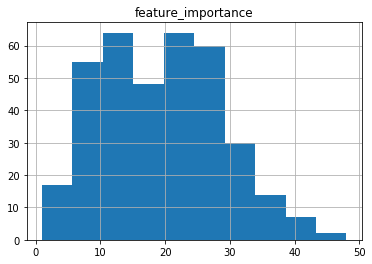

In [93]:
lgbm_feature_importances = pd.DataFrame()
lgbm_feature_importances['feature_name'] = pd.Series(X_train_rf.columns)
lgbm_feature_importances['feature_importance'] = pd.Series(lgbm_reg.feature_importances_)
lgbm_feature_importances = lgbm_feature_importances.sort_values('feature_importance')
lgbm_feature_importances.hist()

In [94]:
lgbm_drop_list = list(lgbm_feature_importances[lgbm_feature_importances['feature_importance'] < 20]['feature_name'].values)
print(len(lgbm_drop_list))
X_train_lgbm = X_train_rf.drop(lgbm_drop_list, axis = 1)
X_test_lgbm = X_test_rf.drop(lgbm_drop_list, axis = 1)

184


In [96]:
# lgbm_params = {'n_estimators': 50000,
#                'objective': 'regression_l1', 
#                'metric': 'mae',
#                'learning_rate': 0.025,
#                "lambda_l1": 0.2,
#                "lambda_l2": 0.2,
#                'max_depth': 10,
#                'num_leaves': 50,
#                'min_data_in_leaf': 100,
#                'bin_size': 32,
#                "feature_fraction": 0.8,
#                "feature_fraction_seed": 42,
#                "bagging_freq": 1,
#                "bagging_fraction": 0.6,
#                "bagging_seed": 42,
#                'n_jobs': 7, 
#                'random_state': 123,
#                'verbosity': -1}
lgbm_params.update(lgbm_random.best_params_)

dtrain_lgb = lgb.Dataset(X_train_lgbm, label=y_train)
cv_result_lgb = lgb.cv(lgbm_params, 
                       dtrain_lgb, 
                       num_boost_round = 10000, 
                       nfold = 5, 
                       metrics = 'mae',
                       early_stopping_rounds = 500, 
                       verbose_eval = 200, 
                       show_stdv = True,
                       stratified = False)
num_boost_rounds_lgb = len(cv_result_lgb['l1-mean'])
print('num_boost_rounds_lgb=' + str(num_boost_rounds_lgb))

lgbm_reg = lgb.train(lgbm_params, dtrain_lgb, num_boost_round=num_boost_rounds_lgb)

lgbm_reg_train_pred = lgbm_reg.predict(X_train_lgbm)
lgbm_reg_train_score = mean_absolute_error(y_train, lgbm_reg_train_pred)

lgbm_reg_test_pred = lgbm_reg.predict(X_test_lgbm)
lgbm_reg_test_score = mean_absolute_error(y_test, lgbm_reg_test_pred)

print('Light GBM Regressor with Cross-Validated Early Stopping')
print(f'Train MAE: {lgbm_reg_train_score}, Test MAE: {lgbm_reg_test_score}')

[200]	cv_agg's l1: 1.99498 + 0.0407542
[400]	cv_agg's l1: 1.99481 + 0.0409604
[600]	cv_agg's l1: 1.99455 + 0.0409903
[800]	cv_agg's l1: 1.99581 + 0.0406808
num_boost_rounds_lgb=491
Light GBM Regressor with Cross-Validated Early Stopping
Train MAE: 1.3239751574410212, Test MAE: 2.056578107895255


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000189073DA048>]],
      dtype=object)

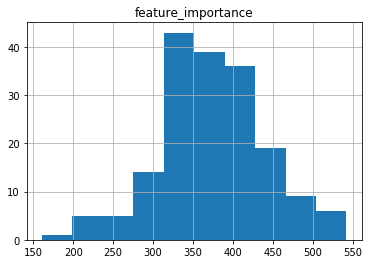

In [97]:
lgbm2_feature_importances = pd.DataFrame()
lgbm2_feature_importances['feature_name'] = pd.Series(X_train_lgbm.columns)
lgbm2_feature_importances['feature_importance'] = pd.Series(lgbm_reg.feature_importance(iteration = -1))
lgbm2_feature_importances = lgbm2_feature_importances.sort_values('feature_importance', ascending = False)
lgbm2_feature_importances.hist()

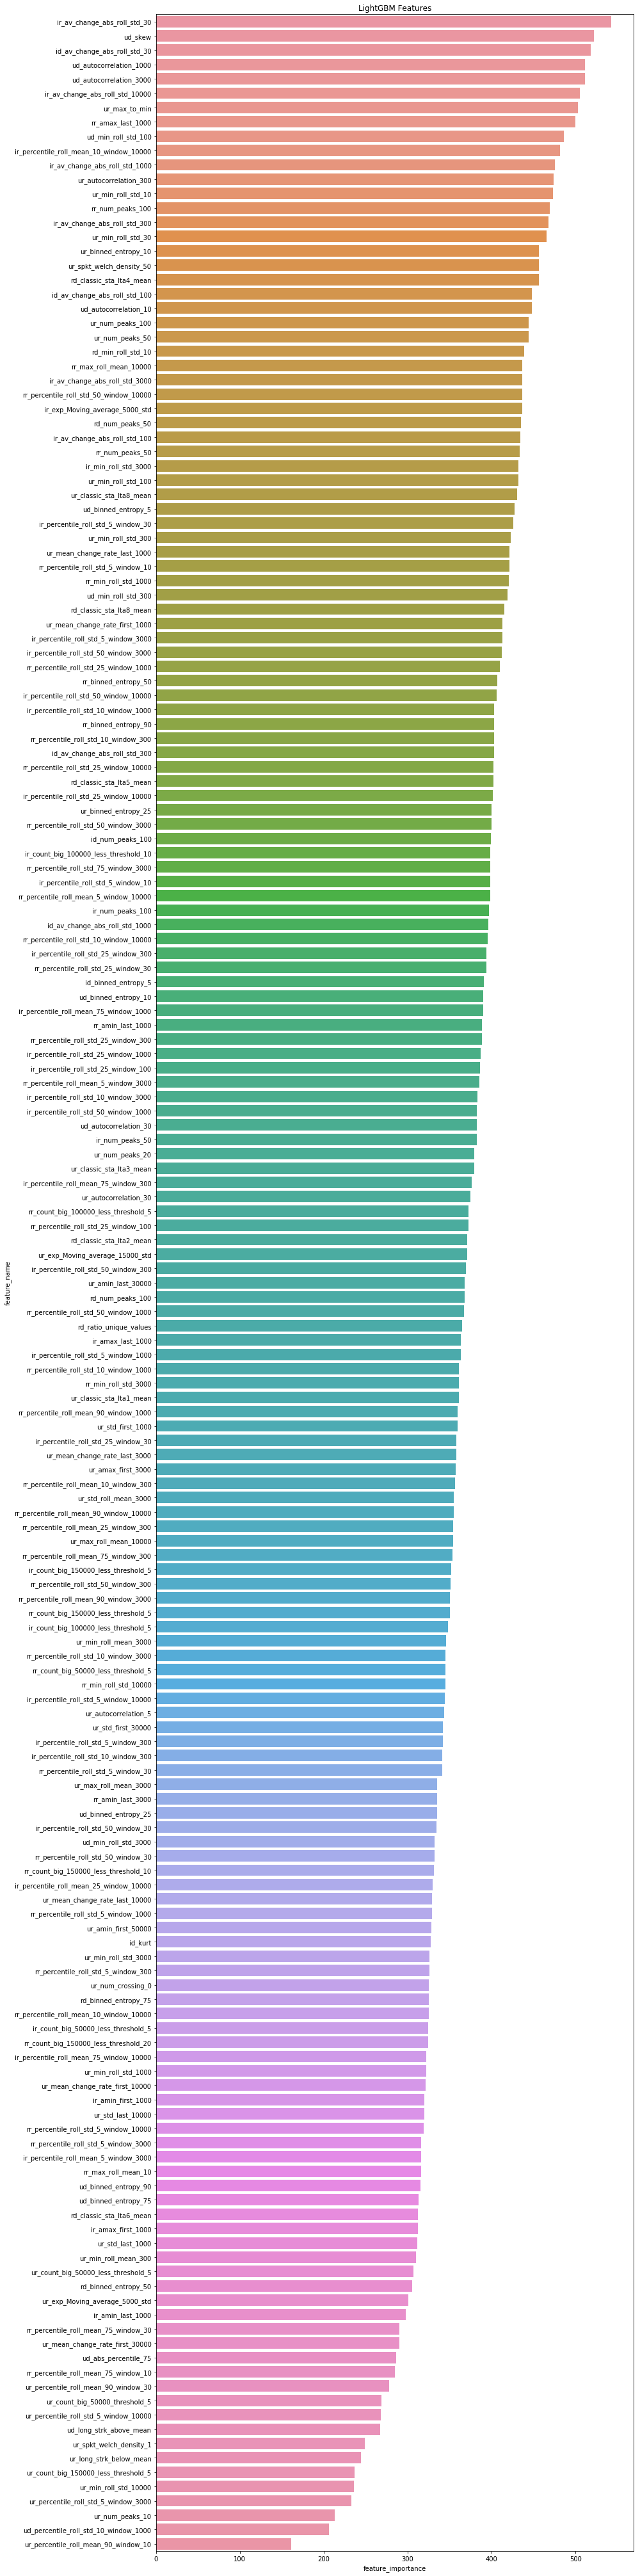

In [98]:
plt.figure(figsize=(14,56))
sns.barplot(x="feature_importance", y="feature_name", data=lgbm2_feature_importances)
plt.title('LightGBM Features')
plt.tight_layout()
plt.savefig(PATH + '/lgbm_importances.png')

In [99]:
lgbm_reg_sub_pred = lgbm_reg.predict(scaled_test_X)
submission = pd.read_csv(PATH + '/sample_submission.csv', index_col='seg_id')
submission.time_to_failure = lgbm_reg_sub_pred
submission.to_csv(PATH + '/submission.csv',index=True)

We run the model. During training for each fold, we validate using the validation set and also we predict using the current model for test set. The final result will be the average over the all folds for the predictions done at each fold training.

## Feature Importances

## Submission 

In [135]:
submission.time_to_failure = predictions
submission.to_csv(PATH + '/submission.csv',index=True)

# Conclusion



* More signal processing
* Tuning feature importance cutoffs
* More hyperparameter tuning
* Conv1D
* Better Data